# Forecasting with Chronos-2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/master/docs/tutorials/timeseries/forecasting-chronos.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/master/docs/tutorials/timeseries/forecasting-chronos.ipynb)

AutoGluon-TimeSeries (AG-TS) includes the [Chronos](https://github.com/amazon-science/chronos-forecasting) family of forecasting models. Chronos models are pretrained on a large collection of real and synthetic time series data, enabling accurate out-of-the-box forecasts on new data.

AG-TS provides a robust and user-friendly way to work with Chronos through the familiar `TimeSeriesPredictor` API. It allows users to backtest models, compare them with other forecasting approaches, and ensemble Chronos with other models to build robust forecasting pipelines. This tutorial demonstrates how to:

- Use Chronos-2 in **zero-shot** mode to generate forecasts without dataset-specific training
- **Fine-tune** Chronos-2 on custom data to improve accuracy

:::{note}

**New in v1.5:** AutoGluon now features [Chronos-2](https://arxiv.org/abs/2510.15821) — the latest version of Chronos models with _zero-shot_ support for covariates and a [90%+ win-rate](https://huggingface.co/spaces/autogluon/fev-bench) over Chronos-Bolt. The older version of this tutorial with the Chronos-Bolt model is available [here](https://auto.gluon.ai/1.4.0/tutorials/timeseries/forecasting-chronos.html).

:::

In [ ]:
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

## Getting started with Chronos-2

Being a pretrained model for zero-shot forecasting, Chronos is different from other models available in AG-TS. 
Specifically, by default, Chronos models do not really `fit` time series data. However, when `predict` is called, they perform _zero-shot inference_ by using the provided contextual information. In this aspect, they behave like local statistical models such as ETS or ARIMA, where all computation happens during inference. 

AutoGluon supports the original Chronos models (e.g., [`chronos-t5-large`](https://huggingface.co/autogluon/chronos-t5-large)), the Chronos-Bolt models (e.g., [`chronos-bolt-base`](https://huggingface.co/autogluon/chronos-bolt-base)), and the latest Chronos-2 models (e.g., [`chronos-2`](https://huggingface.co/autogluon/chronos-2)). The following table compares the capabilities of the three model families.

| Capability | Chronos | Chronos-Bolt | Chronos-2 |
|------------|---------|--------------|-----------|
| Univariate Forecasting | ✅ | ✅ | ✅ |
| Cross-learning across items | ❌ | ❌ | ✅ |
| Multivariate Forecasting | ❌ | ❌ | ✅ |
| Past-only (real/categorical) covariates | ❌ | ❌ | ✅ |
| Known future (real/categorical) covariates | 🧩 | 🧩 | ✅ |
| Fine-tuning support | ✅ | ✅ | ✅ |
| Max. Context Length | 512 | 2048 | 8192 |
| Max. Prediction Length | 64 | 64 | 1024 |


The easiest way to get started with Chronos is through the model-specific presets. 

- **(recommended)** The Chronos-2 models can be accessed using the `"chronos2_small"` and `"chronos2"` presets.
- The Chronos-Bolt️ models can be accessed using the `"bolt_tiny"`, `"bolt_mini"`, `"bolt_small"` and `"bolt_base"` presets.

Alternatively, Chronos models can be combined with other time series models using presets `"medium_quality"`, `"high_quality"` and `"best_quality"`. More details about these presets are available in the documentation for [`TimeSeriesPredictor.fit`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html).


🧩 Chronos/Chronos-Bolt do not natively support future covariates, but they can be combined with external covariate regressors. This only models per-timestep effects, not effects across time. In contrast, Chronos-2 supports all covariate types natively.

## Zero-shot forecasting

### Univariate Forecasting

Let's work with a subset of the [Australian Electricity Demand dataset](https://zenodo.org/records/4659727) to see Chronos-2 in action.

First, we load the dataset as a [TimeSeriesDataFrame](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesDataFrame.html).

In [2]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [3]:
data = TimeSeriesDataFrame.from_path(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/australian_electricity_subset/test.csv"
)
data.head()

target
item_id timestamp                       
T000000 2013-03-10 00:00:00  5207.959961
        2013-03-10 00:30:00  5002.275879
        2013-03-10 01:00:00  4747.569824
        2013-03-10 01:30:00  4544.880859
        2013-03-10 02:00:00  4425.952148

Next, we create the [TimeSeriesPredictor](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html) and select the `"chronos2"` presets to use the Chronos-2 (120M) model in zero-shot mode.

In [4]:
num_test_windows = 3
prediction_length = 48
train_data, test_data = data.train_test_split(num_test_windows * prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data,
    presets="chronos2",
)

Sorting the dataframe index before generating the train/test split.
Beginning AutoGluon training...
AutoGluon will save models to '/fsx/ansarnd/repos/autogluon/docs/tutorials/timeseries/AutogluonModels/ag-20251214_125317'
=================== System Info ===================
AutoGluon Version:  1.4.1b20250910
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #38~22.04.1-Ubuntu SMP Fri Aug 22 15:44:33 UTC 2025
CPU Count:          96
Pytorch Version:    2.7.1+cu126
CUDA Version:       12.6
GPU Memory:         GPU 0: 39.38/39.38 GB
Total GPU Memory:   Free: 39.38 GB, Allocated: 0.00 GB, Total: 39.38 GB
GPU Count:          1
Memory Avail:       1030.21 GB / 1121.80 GB (91.8%)
Disk Space Avail:   1758.43 GB / 11459.15 GB (15.3%)
Setting presets to: chronos2

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos2': {'model_path': 'autogluon/chronos-2'}},
 'known_covariates_names': [],
 'num_val_wi

As promised, Chronos does not take any time to `fit`. The `fit` call merely serves as a proxy for the `TimeSeriesPredictor` to do some of its chores under the hood, such as inferring the frequency of time series and saving the predictor's state to disk. 

Let's use the `predict` method to generate forecasts.

In [5]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: Chronos2


mean          0.1          0.2  \
item_id timestamp                                                    
T000000 2015-02-26 00:00:00  5223.812012  5153.143066  5178.589355   
        2015-02-26 00:30:00  5001.890625  4940.849609  4967.337891   
        2015-02-26 01:00:00  4759.131348  4684.923340  4712.408691   
        2015-02-26 01:30:00  4560.188477  4505.166016  4523.577637   
        2015-02-26 02:00:00  4439.416992  4369.610352  4390.421875   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T000000 2015-02-26 00:00:00  5193.954102  5210.103027  5223.812012   
        2015-02-26 00:30:00  4982.128906  4991.323242  5001.890625   
        2015-02-26 01:00:00  4729.202637  4743.586914  4759.131348   
        2015-02-26 01:30:00  4535.823730  4550.487793  4560.188477   
        2015-02-26 02:00:00  4412.242676  4428.110352  4439.416992   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
T000000 2015-02-26 00:00:00  5234.564453  5248.638672  5265.144531   
        2015-02-26 00:30:00  5012.041504  5026.311523  5047.328125   
        2015-02-26 01:00:00  4770.625977  4784.588379  4803.948242   
        2015-02-26 01:30:00  4580.130859  4591.911133  4615.944336   
        2015-02-26 02:00:00  4456.724121  4474.257324  4496.027832   

                                     0.9  
item_id timestamp                         
T000000 2015-02-26 00:00:00  5295.290527  
        2015-02-26 00:30:00  5078.305664  
        2015-02-26 01:00:00  4828.080078  
        2015-02-26 01:30:00  4636.415039  
        2015-02-26 02:00:00  4509.391602

We get a dataframe with the point forecast (`mean`) and nine quantiles which capture the uncertainty in the forecasts. Custom quantile levels can be specified as follows:
```py
TimeSeriesPredictor(..., quantile_levels=[0.05, 0.1, 0.5, 0.9, 0.95])
```

AG-TS also makes it easy to generate predictions for multiple backtest dates and to visualize the models' predictions.

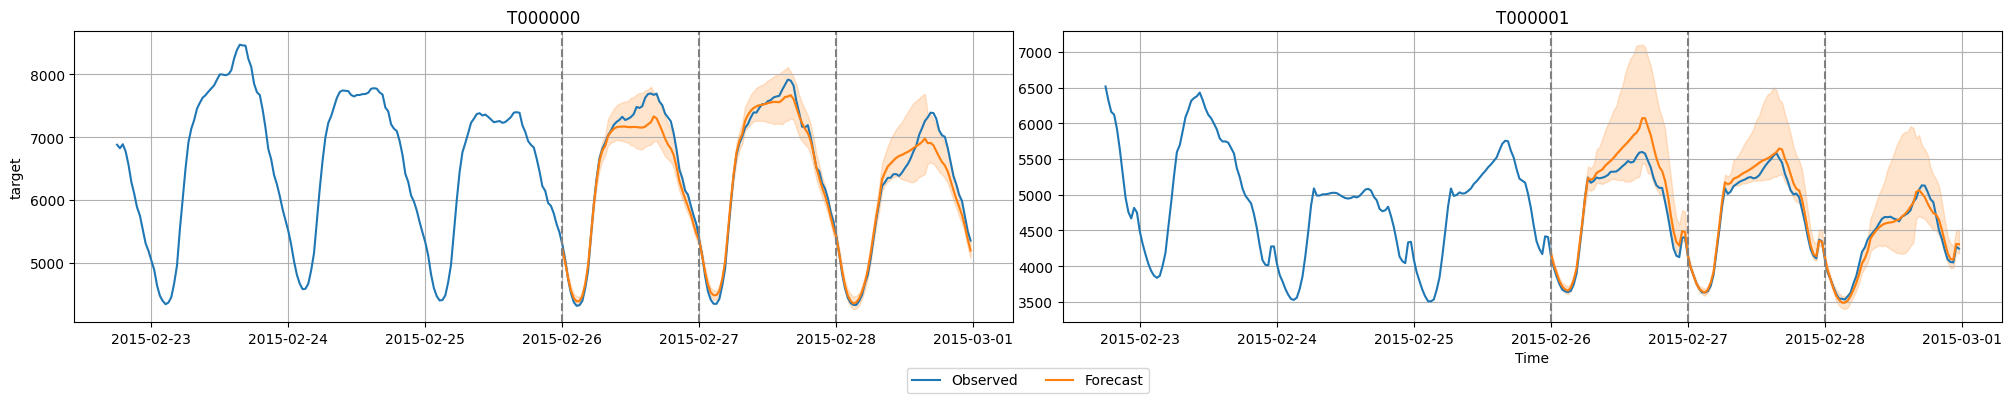

In [6]:
import matplotlib.pyplot as plt

# Generate predictions for multiple windows
predictions_per_window = predictor.backtest_predictions(test_data, num_val_windows=num_test_windows)

# Plot predictions for the first two time series
item_ids = test_data.item_ids[:2].tolist()
all_predictions = pd.concat(predictions_per_window)
predictor.plot(test_data, all_predictions, max_history_length=300, item_ids=item_ids)

# Optional: Plot the cutoff dates with dashed vertical lines
for cutoff in range(-num_test_windows * prediction_length, 0, prediction_length):
    for i, ax in enumerate(plt.gcf().axes):
        cutoff_timestamp = test_data.loc[item_ids[i]].index[cutoff]
        ax.axvline(cutoff_timestamp, color='gray', linestyle='--')
plt.show()

## Forecasting with covariates

The previous example showed Chronos-2 in action on a univariate forecasting task, i.e., only the historical data of the target time series for making predictions. However, in real-world scenarios, additional exogenous information related to the target series (e.g., weather forecasts, holidays, promotions) is often available. These exogenous time series, often referred to as covariates, may either be observed only in the past (past-only) or also in the forecast horizon (known future). Leveraging this information when making predictions can improve forecast accuracy. 

Chronos-2 natively supports (dynamic) covariates, past-only and known-future, real-valued or categorical. Let's see how we can use Chronos-2 to forecast with covariates on a **Electrical Load Forecasting** task.

In [7]:
data = TimeSeriesDataFrame.from_path(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/bull/test.parquet", id_column="id"
)
data.head()

load  airtemperature  \
item_id                timestamp                                     
Bull_education_Magaret 2016-01-01 00:00:00  0.0000             9.4   
                       2016-01-01 01:00:00  2.7908             8.9   
                       2016-01-01 02:00:00  3.7210             8.9   
                       2016-01-01 03:00:00  2.7908             8.3   
                       2016-01-01 04:00:00  9.3025             7.8   

                                            dewtemperature  sealvlpressure  
item_id                timestamp                                            
Bull_education_Magaret 2016-01-01 00:00:00             3.3     1028.699951  
                       2016-01-01 01:00:00             2.2     1028.800049  
                       2016-01-01 02:00:00             2.2     1029.599976  
                       2016-01-01 03:00:00             1.7     1029.500000  
                       2016-01-01 04:00:00             1.7     1029.599976

The goal is to forecast next day's (24 hours) load using historical load and known weather covariates: air temperature, dew temperature and sea level pressure. Since future weather information is not known in advance, weather forecasts are typically used as known covariates.

In [8]:
prediction_length = 24
train_data, test_data = data.train_test_split(prediction_length=prediction_length)

Sorting the dataframe index before generating the train/test split.


The following code uses Chronos-2 in the TimeSeriesPredictor to forecast the `load` for the next 24 hours. We use the _univariate_ [Chronos-Bolt (Small)](https://huggingface.co/autogluon/chronos-bolt-small) model as a baseline for comparison.

Note that we have specified the target column we are interested in forecasting and the names of known covariates while constructing the TimeSeriesPredictor. Any other columns, if present, will be used as past-only covariates.

In [9]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="load",
    known_covariates_names=["airtemperature", "dewtemperature", "sealvlpressure"],
    eval_metric="MASE",
).fit(
    train_data,
    hyperparameters={"Chronos": {}, "Chronos2": {}},
    enable_ensemble=False,
    time_limit=60,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/fsx/ansarnd/repos/autogluon/docs/tutorials/timeseries/AutogluonModels/ag-20251214_125334'
=================== System Info ===================
AutoGluon Version:  1.4.1b20250910
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #38~22.04.1-Ubuntu SMP Fri Aug 22 15:44:33 UTC 2025
CPU Count:          96
Pytorch Version:    2.7.1+cu126
CUDA Version:       12.6
GPU Memory:         GPU 0: 39.37/39.38 GB
Total GPU Memory:   Free: 39.37 GB, Allocated: 0.01 GB, Total: 39.38 GB
GPU Count:          1
Memory Avail:       1029.12 GB / 1121.80 GB (91.7%)
Disk Space Avail:   1758.43 GB / 11459.15 GB (15.3%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos': {}, 'Chronos2': {}},
 'known_covariates_names': ['airtemperature',
                            'dewtemperature',
                            'sealvlpressure'],
 '

Once the predictor has been fit, we can evaluate it on the test dataset and generate the leaderboard. We see that Chronos-2, which utilizes covariates, produces a significantly more accurate forecast on the test set compared to Chronos-Bolt, which does not utilize covariates.

Note that all AutoGluon-TimeSeries models report scores in a "higher is better" format, meaning that most forecasting error metrics like MASE are multiplied by -1 when reported.

In [10]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Chronos2,-0.696239,-0.817203,2.261695,1.600290,0.782884,2
1,Chronos[autogluon__chronos-bolt-small],-1.278404,-1.086471,0.618992,0.576958,1.233093,1


We can also use the predictor to compute features importances to understand which exogenous features are affecting the prediction accuracy the most.

In [11]:
predictor.feature_importance(test_data, model="Chronos2", relative_scores=True)

Computing feature importance
Subsample_size 50 is larger than the number of items in the data and will be ignored


,importance,stdev,n,p99_low,p99_high
airtemperature,0.324309,0.0,5.0,0.324309,0.324309
dewtemperature,0.057110,0.0,5.0,0.057110,0.057110
sealvlpressure,0.038278,0.0,5.0,0.038278,0.038278


With `relative_scores=True`, this method returns relative (percentage) improvements in the `eval_metric` due to each feature. In this example, the `airtemperature` feature is the most important for accurate forecasting, yielding a ~32% error reduction on the test set.

Note that covariates may not always be useful and using more covariates does not necessarily imply more accurate forecasts. With Chronos-2, AutoGluon makes it easy for users to quickly validate different configurations and find ones that perform best on held-out data. 

## Fine-tuning 

We have seen above how Chronos-2 models can produce forecasts in zero-shot mode, both with and without covariates. AutoGluon also makes it easy to fine-tune Chronos models on a specific dataset to maximize the predictive accuracy.

The following snippet specifies two settings for the Chronos-2 model: zero-shot and fine-tuned. `TimeSeriesPredictor` will perform a lightweight fine-tuning of the pretrained model on the provided training data. We add name suffixes to easily identify the zero-shot and fine-tuned versions of the model.

:::{note}

If you are fine-tuning on a machine with multiple GPUs, we strongly recommend setting the `CUDA_VISIBLE_DEVICES` environment variable to ensure that only a single GPU is visible. 

:::

In [12]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="load",
    known_covariates_names=["airtemperature", "dewtemperature", "sealvlpressure"],
    eval_metric="MASE",
).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos2": [
            # Zero-shot model
            {"ag_args": {"name_suffix": "ZeroShot"}},
            # Fine-tuned model
            {"fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=300,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to '/fsx/ansarnd/repos/autogluon/docs/tutorials/timeseries/AutogluonModels/ag-20251214_125418'
=================== System Info ===================
AutoGluon Version:  1.4.1b20250910
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #38~22.04.1-Ubuntu SMP Fri Aug 22 15:44:33 UTC 2025
CPU Count:          96
Pytorch Version:    2.7.1+cu126
CUDA Version:       12.6
GPU Memory:         GPU 0: 39.37/39.38 GB
Total GPU Memory:   Free: 39.37 GB, Allocated: 0.01 GB, Total: 39.38 GB
GPU Count:          1
Memory Avail:       1028.93 GB / 1121.80 GB (91.7%)
Disk Space Avail:   1758.40 GB / 11459.15 GB (15.3%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos2': [{'ag_args': {'name_suffix': 'ZeroShot'}},
                                  {'ag_args': {'name_suffix': 'FineTuned'},
                                   'fine_

Here we used the default fine-tuning configuration for Chronos-2 by only specifying `"fine_tune": True`. By default, Chronos-2 is fine-tuned with a low-rank adapter (LoRA) to reduce memory and disk footprint. AutoGluon makes it easy to change other parameters for fine-tuning such as the mode, number of steps or learning rate.
```python
predictor.fit(
    ...,
    hyperparameters={"Chronos2": {"fine_tune": True, "fine_tune_mode": "full", "fine_tune_lr": 1e-4, "fine_tune_steps": 2000, "fine_tune_batch_size": 32}},
)
```

For the full list of fine-tuning options, see the Chronos-2 documentation in [Forecasting Model Zoo](forecasting-model-zoo.md#autogluon.timeseries.models.Chronos2Model).


After fitting, we can evaluate the two model variants on the test data and generate a leaderboard.

In [13]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Chronos2FineTuned,-0.677888,-0.802909,2.510460,0.773595,123.887496,2
1,Chronos2ZeroShot,-0.696239,-0.817203,2.385682,1.586984,0.885827,1


Fine-tuning resulted in a more accurate model, as shown by the better `score_test` on the test set.

## FAQ


#### How accurate is Chronos-2?

Chronos-2 is the best performing (last updated: Dec 2025) time series foundation model across multiple benchmarks, including [fev-bench](https://huggingface.co/spaces/autogluon/fev-bench), [GIFT-Eval](https://huggingface.co/spaces/Salesforce/GIFT-Eval) and [Chronos Bench II](https://arxiv.org/abs/2403.07815). Details empirical results can be found in the [Chronos-2 technical report](https://arxiv.org/abs/2510.15821). The accuracy of Chronos-2 often exceeds statistical baseline models and task-specific deep learning models such as `DeepAR` and `TemporalFusionTransformer`.

#### Does fine-tuning always improve Chronos-2's forecasting accuracy?

Fine-tuning a foundation model like Chronos-2 involves many hyperparameter choices. AG-TS provides reasonable defaults that performed well in large-scale benchmarking, but they may not be optimal for every use case. We recommend fine-tuning only when you have a reasonable number of time series and sufficient historical data (e.g., >100 time series with a median history length larger than `3 * prediction_length`), as limited data can lead to overfitting or degraded performance. If you observe degraded accuracy, we recommend increasing the size of the training data and experimenting with different fine-tuning hyperparameters.

Alternatively, you can use an ensemble of zero-shot Chronos-2 and fine-tuned Chronos-2 (Small) to construct a robust predictor, available via the `chronos2_ensemble` preset:

```py
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    ...,
    presets="chronos2_ensemble",
)
```

#### What is the recommended hardware for running Chronos models?

We recommend using a machine with a GPU for best performance, especially for fine-tuning. For reference, we tested the models on AWS `g5.2xlarge` instances with NVIDIA A10G GPUs (24 GiB GPU memory) and 32 GiB of system memory. However, Chronos-2, Chronos-Bolt, and Chronos (up to small size) can also run on consumer GPUs and CPUs with reasonable inference times.

#### Why do my predictions change with the `batch_size`?

By default, AutoGluon enables Chronos-2’s cross_learning mode, where the model makes joint predictions across time series within a batch. This often improves accuracy but also makes results sensitive to the `batch_size`. You can disable this mode with:

```python
predictor.fit(
    ...,
    hyperparameters={"Chronos2": {"cross_learning": False}},
)
```

#### Where can I ask specific questions on Chronos?

Members of the AutoGluon team are among the core developers of Chronos. So you can ask Chronos-related questions on [AutoGluon's GitHub](https://github.com/autogluon/autogluon) or on [Chronos' GitHub](https://github.com/amazon-science/chronos-forecasting/discussions).